<a href="https://colab.research.google.com/github/Asruz/Tugas-Matdis/blob/main/Tugas_4_Matdis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === load data
makan = pd.read_csv("/content/makanan.csv")

# === parameter dasar
NPM = 19102
np.random.seed(NPM)

budget0 = 1e6 #rupiah

wkenyang_base= 0.8
wrasa_base= 0.7
wsehat_base= 0.9
wbosan_base= 0.2

SAMPLE_NUM= 500
SISA_MININUM= 150e3
SISA_MAKSIMUM= 300e3
bin_sisa= np.arange(SISA_MININUM, SISA_MAKSIMUM, 1000)

# === arrays
sampleid= np.arange(0, SAMPLE_NUM)
skor= np.zeros(SAMPLE_NUM)
sisa= np.zeros(SAMPLE_NUM)
sehat= np.zeros(SAMPLE_NUM)
resp_sehat= np.zeros((SAMPLE_NUM, len(bin_sisa)))
resp_pilih= np.zeros((SAMPLE_NUM, 62))  # 31 hari × 2 makan

# === simulasi
for n in range(SAMPLE_NUM):
    budget=budget0
    skor_kumulatif= 0
    skor_sehat= 0

    for i in range(31): # hari
        # makan pertama
        pilihan= np.random.randint(0, len(makan))
        w_kenyang= np.random.normal(loc=wkenyang_base, scale=0.2)
        w_rasa= np.random.normal(loc=wrasa_base, scale=0.2)
        w_sehat= np.random.normal(loc=wsehat_base, scale=0.4)
        w_bosan= np.random.normal(loc=wbosan_base, scale=0.2)
        skor_kumulatif += (w_kenyang * makan['kenyang'][pilihan]
                          + w_rasa * makan['rasa'][pilihan]
                          + w_sehat * makan['sehat'][pilihan]
                          - w_bosan * makan['bosan'][pilihan])
        skor_sehat += makan['sehat'][pilihan] - 0.5
        budget -= makan['harga'][pilihan]
        resp_pilih[n][i*2]= pilihan

        # makan kedua
        pilihan= np.random.randint(0, len(makan))
        w_kenyang= np.random.normal(loc=wkenyang_base, scale=0.2)
        w_rasa= np.random.normal(loc=wrasa_base, scale=0.2)
        w_sehat= np.random.normal(loc=wsehat_base+0.2, scale=0.4)
        w_bosan= np.random.normal(loc=wbosan_base*2, scale=0.2)
        skor_kumulatif += (w_kenyang * makan['kenyang'][pilihan]
                          + w_rasa * makan['rasa'][pilihan]
                          + w_sehat * makan['sehat'][pilihan]
                          - w_bosan * makan['bosan'][pilihan])
        skor_sehat += makan['sehat'][pilihan] - 0.5
        budget -= makan['harga'][pilihan]
        resp_pilih[n][i*2+1]= pilihan

    sisa[n]= budget
    skor[n]= skor_kumulatif
    sehat[n]= skor_sehat

    idx_raw=(budget-SISA_MININUM)/1000
    if np.isfinite(idx_raw) and 0<=idx_raw<len(bin_sisa):
        idx=int(idx_raw)
        resp_sehat[n][idx]=skor_sehat

# === (3) titik dengan skor skumulatif terbesar (skor) di mana nilai kumulatif kesehatannya positif
mask3=(sehat>0) & (sisa>0)
idx_max_skor=np.argmax(np.where(mask3, skor, -np.inf))
max_skor_value=skor[idx_max_skor]
max_skor_sehat=sehat[idx_max_skor]
max_skor_sisa=sisa[idx_max_skor]

# === (4) tampilkan jadwal makanan sesuai pilihan (resp_pilih)
jadwal_makanan=pd.DataFrame(resp_pilih[idx_max_skor,:],columns=['Index_Makanan'])
jadwal_makanan['Nama_Makanan']=jadwal_makanan['Index_Makanan'].apply(
    lambda x: makan['makanan'][int(x)] if x<len(makan) else None)

# tampilkan di colab
print("=== Jadwal makanan terbaik (index & nama) ===")
display(jadwal_makanan)

print("\nSkor kumulatif terbesar:", max_skor_value)
print("Nilai sehat kumulatif:", max_skor_sehat)
print("Sisa uang bulanan:", max_skor_sisa)


=== Jadwal makanan terbaik (index & nama) ===


,Index_Makanan,Nama_Makanan
0,4.0,cireng
1,11.0,nasi telur
2,12.0,warteg
3,12.0,warteg
4,2.0,mieayam
...,...,...
57,9.0,mi instan
58,7.0,gorengan
59,10.0,roti
60,8.0,capcay



Skor kumulatif terbesar: 88.19157153488203
Nilai sehat kumulatif: 0.6000000000000009
Sisa uang bulanan: nan


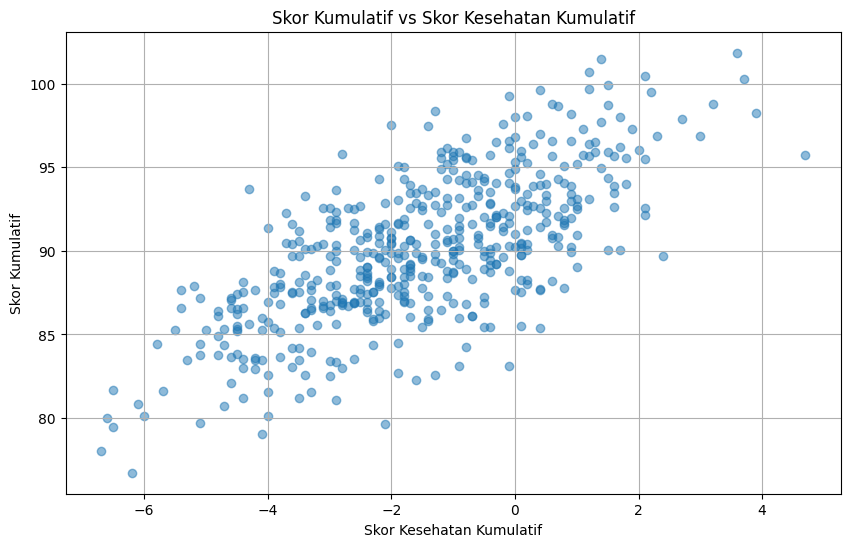

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(sehat, skor, alpha=0.5)
plt.xlabel("Skor Kesehatan Kumulatif")
plt.ylabel("Skor Kumulatif")
plt.title("Skor Kumulatif vs Skor Kesehatan Kumulatif")
plt.grid(True)
plt.show()

# Task
Visualize the average cumulative score and average cumulative health score for each food item from the simulation results.

## Process simulation results

### Subtask:
Reshape the `resp_pilih` array to associate each chosen food item index with the corresponding cumulative score and cumulative health score for each sample.


**Reasoning**:
Reshape and combine the simulation results to associate food item choices with their corresponding scores and health scores.



In [18]:
reshaped_resp_pilih = resp_pilih.reshape(-1, 1)
repeated_skor = np.repeat(skor, resp_pilih.shape[1]).reshape(-1, 1)
repeated_sehat = np.repeat(sehat, resp_pilih.shape[1]).reshape(-1, 1)

combined_results = np.concatenate([reshaped_resp_pilih, repeated_skor, repeated_sehat], axis=1)
df_combined_results = pd.DataFrame(combined_results, columns=['food_index', 'cumulative_score', 'cumulative_health_score'])

## Map food index to name

### Subtask:
Use the `makan` DataFrame to map the food item indices to their actual names.


**Reasoning**:
Merge the `df_combined_results` DataFrame with the `makan` DataFrame based on the food index and select the required columns to prepare for calculating the average scores per food item.



In [19]:
merged_df = pd.merge(df_combined_results, makan, left_on='food_index', right_index=True, how='left')
df_for_averages = merged_df[['makanan', 'cumulative_score', 'cumulative_health_score']]

## Calculate averages

### Subtask:
Group the processed data by food item name and calculate the average cumulative score and average cumulative health score for each food item.


**Reasoning**:
Group the dataframe by 'makanan' and calculate the mean of the score and health score columns to find the average for each food item.



In [20]:
average_skor_by_food = df_for_averages.groupby('makanan')[['cumulative_score', 'cumulative_health_score']].mean().reset_index()

**Reasoning**:
Display the resulting DataFrame containing the average scores by food item.



In [21]:
display(average_skor_by_food)

,makanan,cumulative_score,cumulative_health_score
0,ayamgeprek,90.314299,-1.475886
1,bakso,90.142232,-1.669813
2,capcay,90.304708,-1.116445
3,cireng,89.773167,-1.533943
4,gorengan,89.310324,-1.813840
5,mi instan,89.499709,-1.898831
6,mieayam,90.612749,-1.392712
7,nasi telur,89.851524,-1.619581
8,nasigoreng,90.568139,-1.284082
9,nasipadang,90.686546,-1.263023


## Visualize average scores

### Subtask:
Create a histogram (or bar chart) to visualize the average cumulative score for each food item.


**Reasoning**:
Create a bar chart to visualize the average cumulative score for each food item using the `average_skor_by_food` DataFrame.



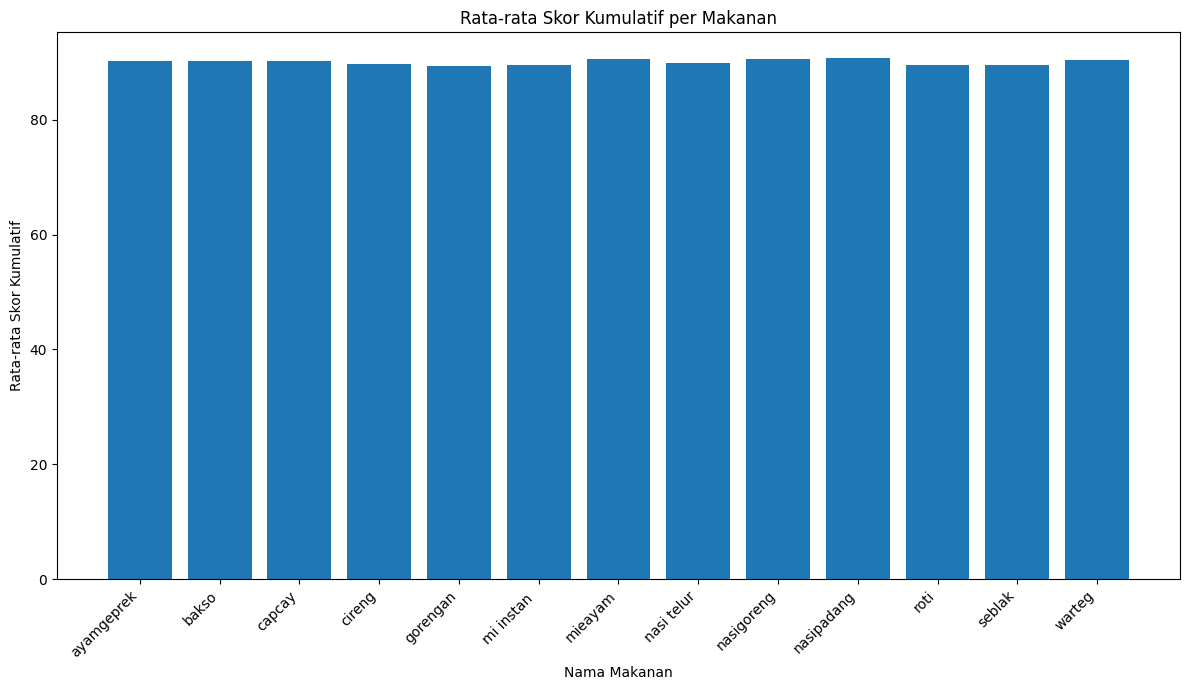

In [22]:
plt.figure(figsize=(12, 7))
plt.bar(average_skor_by_food['makanan'], average_skor_by_food['cumulative_score'])
plt.xlabel("Nama Makanan")
plt.ylabel("Rata-rata Skor Kumulatif")
plt.title("Rata-rata Skor Kumulatif per Makanan")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Visualize average health scores

### Subtask:
Create a histogram (or bar chart) to visualize the average cumulative health score for each food item.


**Reasoning**:
Generate a bar chart to visualize the average cumulative health score for each food item using the previously calculated averages.



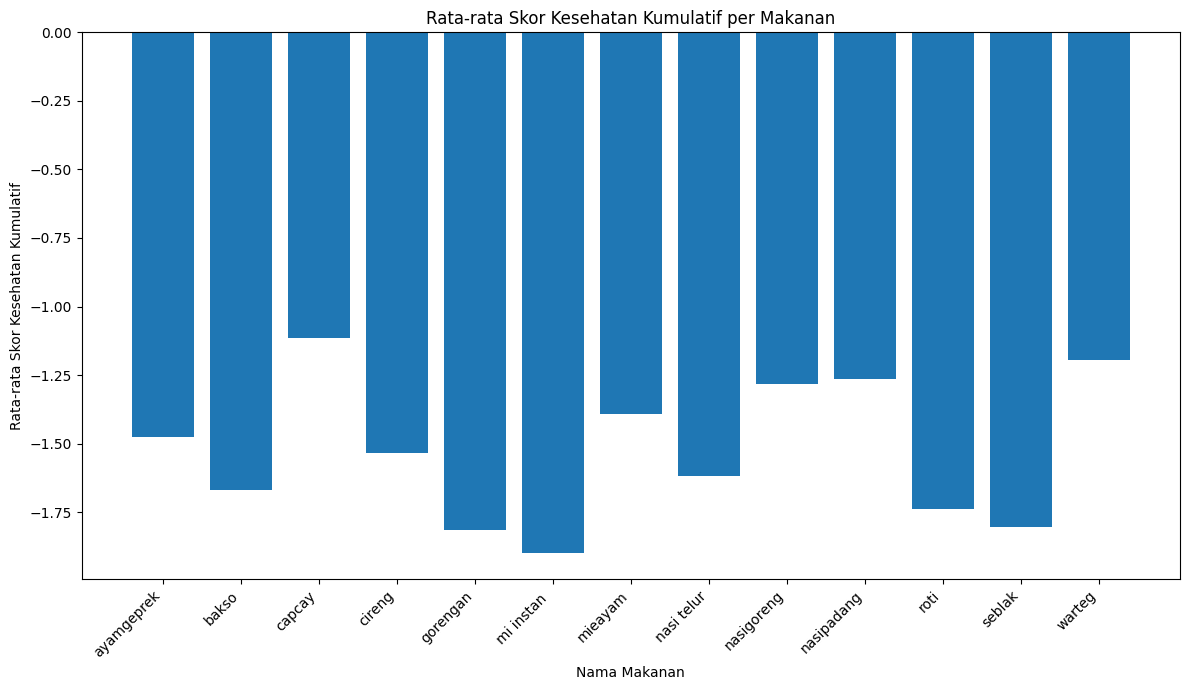

In [25]:
plt.figure(figsize=(12, 7))
plt.bar(average_skor_by_food['makanan'], average_skor_by_food['cumulative_health_score'])
plt.xlabel("Nama Makanan")
plt.ylabel("Rata-rata Skor Kesehatan Kumulatif")
plt.title("Rata-rata Skor Kesehatan Kumulatif per Makanan")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   The average cumulative score and average cumulative health score were calculated for each food item.
*   Bar charts were generated to visualize both the average cumulative score and average cumulative health score for each food item.

### Insights or Next Steps

*   Compare the average cumulative scores and average cumulative health scores to understand which food items contribute more to both overall score and health score in the simulation.
*   Consider performing further analysis on the distribution of cumulative scores and health scores for each food item, perhaps using box plots, to see the variability beyond the average.
